In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras import models,layers

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
 'PlantVillage',
  shuffle=True,
  image_size=(IMAGE_SIZE,IMAGE_SIZE),
  batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names= dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 1 0 1 0 0 2 2 0 0 1 0 0 0 0 1 0 0 0 2 1 0 0 1 0 1 0 1 0 2 2]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


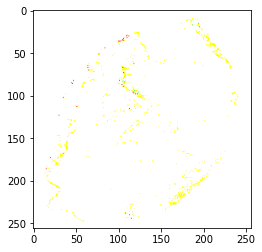

In [6]:
for image_batch,label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy())
    

# for displaying class

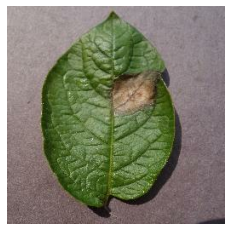

In [7]:
for image_batch,label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.axis('off')

# for displaying class

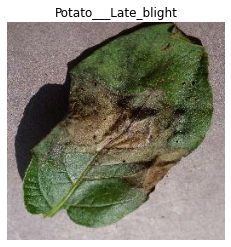

In [8]:
for image_batch,label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.title(class_names[label_batch[0]])
    plt.axis('off')

# For Plotting 12 images from 1 Batch

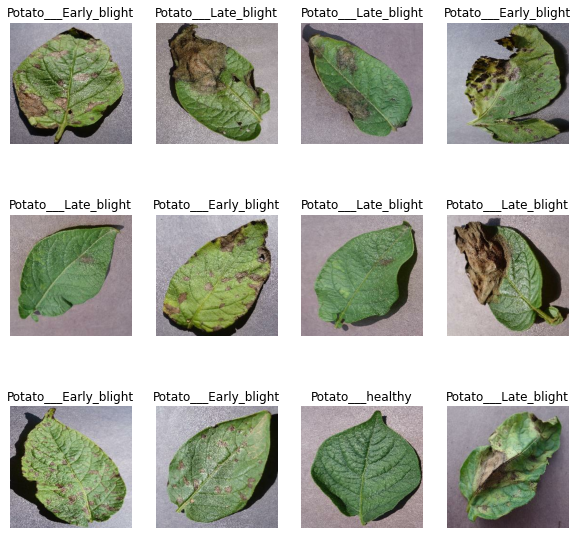

In [9]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [10]:
len(dataset)

68

In [13]:
train_size=.8
len(dataset)*train_size

54.400000000000006

In [14]:
train_ds = dataset.take(54)
len(train_ds)

54

In [15]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [16]:
val_size=.1
len(dataset)*val_size

6.800000000000001

In [17]:
val_ds=test_ds.take(6)
val_ds

<TakeDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [18]:
len(val_ds)

6

In [19]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [20]:
def get_dataset_partitions_tf(ds,train_split=.8,test_split=.1,val_split=.1,shuffle=True,shuffle_size=10000):
    
    ds_size=len(ds)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    
    train_size=int(ds_size*train_split)
    
    val_size= int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    
    val_ds=ds.skip(train_size).take(val_size)
    
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [21]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [22]:
len(train_ds)

54

In [23]:
len(val_ds)

6

In [24]:
len(test_ds)

8

In [25]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [26]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [27]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [28]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
    
])

model.build(input_shape=input_shape)

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [30]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [31]:

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 88s 1s/step - loss: 0.8463 - accuracy: 0.5712 - val_loss: 0.6934 - val_accuracy: 0.7292
Epoch 2/50
54/54 [==============================] - 74s 1s/step - loss: 0.5338 - accuracy: 0.7726 - val_loss: 0.3638 - val_accuracy: 0.8438
Epoch 3/50
54/54 [==============================] - 85s 2s/step - loss: 0.3115 - accuracy: 0.8808 - val_loss: 0.1876 - val_accuracy: 0.9271
Epoch 4/50
54/54 [==============================] - 82s 2s/step - loss: 0.3506 - accuracy: 0.8611 - val_loss: 0.2671 - val_accuracy: 0.9167
Epoch 5/50
54/54 [==============================] - 80s 1s/step - loss: 0.2641 - accuracy: 0.8987 - val_loss: 0.4767 - val_accuracy: 0.8385
Epoch 6/50
54/54 [==============================] - 78s 1s/step - loss: 0.2358 - accuracy: 0.9068 - val_loss: 0.2714 - val_accuracy: 0.8906
Epoch 7/50
54/54 [==============================] - 79s 1s/step - loss: 0.1448 - accuracy: 0.9468 - val_loss: 0.0791 - val_accuracy: 0.9740
Epoch 8/50
54/54 [==

In [33]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 308ms/step - loss: 0.0098 - accuracy: 0.9961


In [34]:

scores

[0.00981855858117342, 0.99609375]

In [35]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [36]:

history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:

type(history.history['loss'])

list

In [38]:
len(history.history['loss'])

50

In [39]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.8462570905685425,
 0.5338120460510254,
 0.31149619817733765,
 0.35056155920028687,
 0.264085978269577]

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

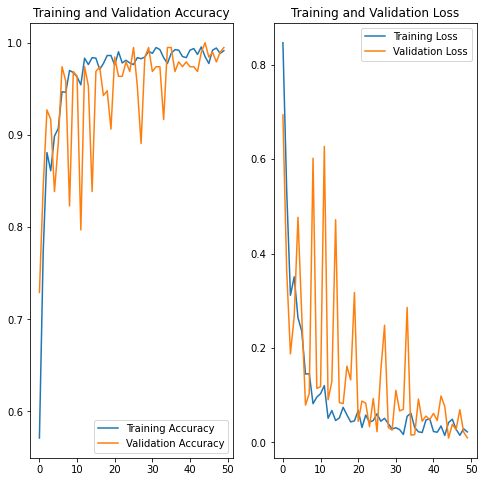

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
predicted label: Potato___Late_blight


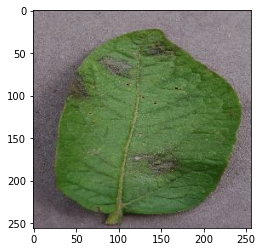

In [42]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [43]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

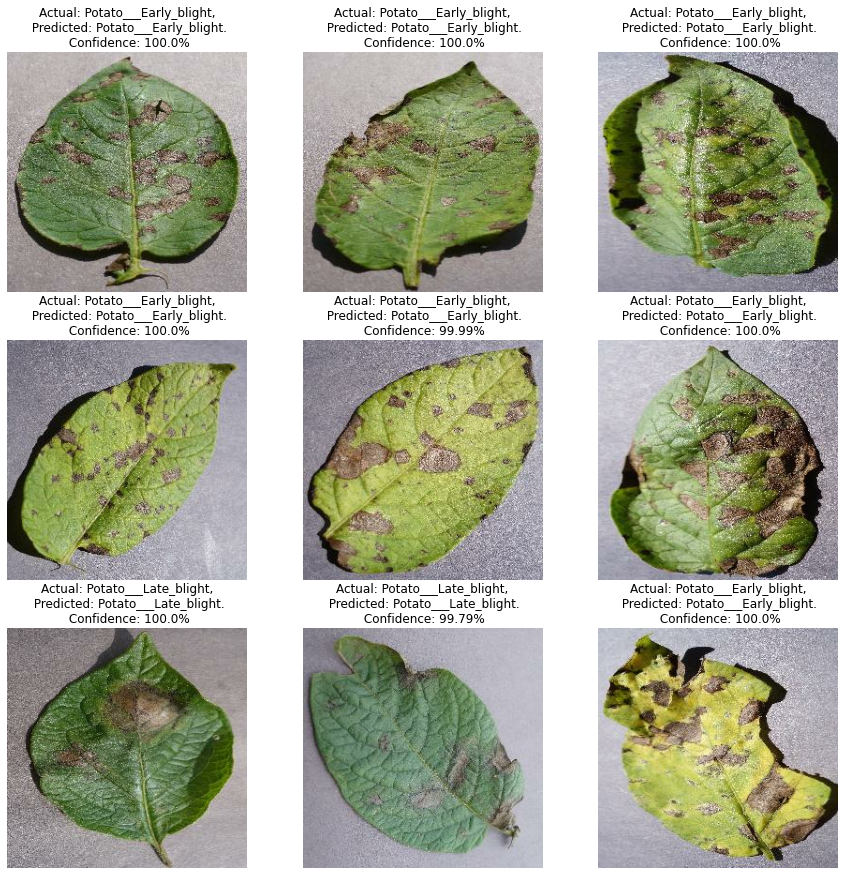

In [45]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Saving the Model

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

In [48]:
model.save("../potatoes.h5")